In [32]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# from astropy.coordinates import EarthLocation,SkyCoord
# from astropy.time import Time
# from astropy import units as u
# from astropy.coordinates import AltAz

import json
from glob import glob

# from uncertainties import unumpy as unp
# from uncertainties import ufloat, umath

from options import *
from constants import *

# nom_vals = unp.nominal_values
# std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [33]:
NFFT = 1024
SAMPLE_RATE = 2_048_000

In [34]:
def load(dataset: str):
    raw_data = np.fromfile(dataset, np.complex64)
    with open(dataset.replace("raw.dat", "params.json"), "r") as file:
        params = json.load(file)
    
    spectrum, frequencies = mlab.psd(raw_data, NFFT=NFFT, Fs=SAMPLE_RATE)
    frequencies += params['frequency']

    return (spectrum, frequencies), params

In [35]:
datasets = []
for run in glob('../data/*calibration*.dat'):
    print(run)
    datasets.append(load(run))

../data/calibration_0_-5_2025_02_21_16_03_06_raw.dat
../data/calibration_0_-4_2025_02_21_15_49_45_raw.dat
../data/calibration_1_-2_2025_02_21_15_38_49_raw.dat
../data/calibration_5_-4_2025_02_21_15_54_56_raw.dat
../data/calibration_3_-2_2025_02_21_15_40_42_raw.dat
../data/calibration_1_-4_2025_02_21_15_50_46_raw.dat
../data/calibration_0_0_2025_02_21_15_23_20_raw.dat
../data/calibration_5_-1_2025_02_21_15_31_02_raw.dat
../data/calibration_4_-2_2025_02_21_15_41_45_raw.dat
../data/calibration_2_0_2025_02_21_15_26_03_raw.dat
../data/calibration_5_-2_2025_02_21_15_42_43_raw.dat
../data/calibration_5_0_2025_02_21_15_29_55_raw.dat
../data/calibration_4_-3_2025_02_21_15_44_34_raw.dat
../data/calibration_2_-1_2025_02_21_15_34_18_raw.dat
../data/calibration_1_-5_2025_02_21_16_01_49_raw.dat
../data/calibration_4_-1_2025_02_21_15_32_15_raw.dat
../data/calibration_4_-4_2025_02_21_15_54_02_raw.dat
../data/calibration_3_-4_2025_02_21_15_53_03_raw.dat
../data/calibration_4_-5_2025_02_21_15_57_55_raw.

In [36]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [47]:
def plot_ra_dec(datasets: list, reference_position: tuple[float, float], rel : bool = False):
    ra = [param.get('ra_dec')[0] for (_, _), param in datasets]
    dec = [param.get('ra_dec')[1] for (_, _), param in datasets]

    ra_rel = [r - reference_position[0] for r in ra]
    dec_rel = [d - reference_position[1] for d in dec]

    averages = [calculate_average(spectrum) for (spectrum, _), _ in datasets]

    if (rel):
        plt.scatter(ra_rel, dec_rel, c=averages)
        plt.scatter(0,0, marker='o', s=50, label="Sun")
        plt.xlabel(r"Relative Ra [$^\circ$]")
        plt.ylabel(r"Relative Dec [$^\circ$]")
    else:
        plt.scatter(ra, dec, c=averages)
        plt.scatter(*reference_position, marker='o', s=50, label="Sun")
        plt.xlabel(r"Ra [$^\circ$]")
        plt.ylabel(r"Dec [$^\circ$]")

    plt.legend()


In [48]:
def plot_az_alt(datasets: list, reference_position: tuple[float, float], rel: bool = False):
    az = [param.get('az_alt')[0] for (_, _), param in datasets]
    alt = [param.get('az_alt')[1] for (_, _), param in datasets]

    az_rel = [r - reference_position[0] for r in az]
    alt_rel = [d - reference_position[1] for d in alt]

    averages = [calculate_average(spectrum) for (spectrum, _), _ in datasets]

    if (rel):
        plt.scatter(az_rel, alt_rel, c=averages)
        plt.scatter(0,0, marker='o', s=50, label="Sun")
        plt.xlabel(r"Relative Ra [$^\circ$]")
        plt.ylabel(r"Relative Dec [$^\circ$]")
    else:
        plt.scatter(az, alt, c=averages)
        plt.scatter(*reference_position, marker='o', s=50, label="Sun")
        plt.xlabel(r"Ra [$^\circ$]")
        plt.ylabel(r"Dec [$^\circ$]")

In [39]:
def estimate_correction_az_alt(datasets: list, reference_position: tuple[float, float]) -> tuple[float, float]:
    az_alt = [param.get('az_alt') for (_, _), param in datasets]

    az_alt_rel = [(r[0] - reference_position[0], r[1] - reference_position[1]) for r in az_alt]

    averages = [calculate_average(spectrum) for (spectrum, _), _ in datasets]

    idx_max = np.argmax(averages)
    correction = az_alt_rel[idx_max]

    return correction

In [40]:
def get_corrected_target_ra_dec(target_position_ra_dec, correction_az_alt):
    observing_location = EarthLocation(lat='46.519611', lon='6.565056', height=400*u.m)  
    observing_time = Time('2017-02-05 20:12:18')  
    aa = AltAz(location=observing_location, obstime=observing_time)

    coord = SkyCoord('4h42m', '-38d6m50.8s')
    coord.transform_to(aa)

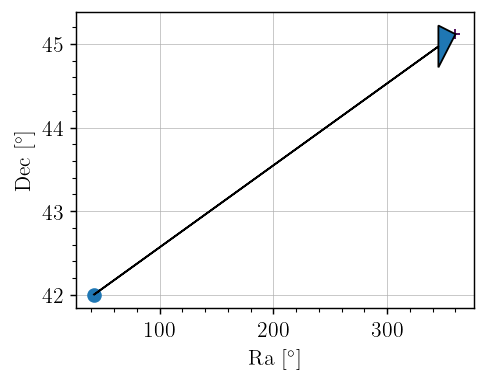

In [41]:
# Testing
stuff = [load('../data/test1_2025_02_21_10_20_51_raw.dat')]
x, y = estimate_correction_az_alt(stuff, (42, 42))
plot_az_alt(stuff, (42, 42))
plt.arrow(42, 42, x, y, length_includes_head=True, head_width=0.5, head_length=15)

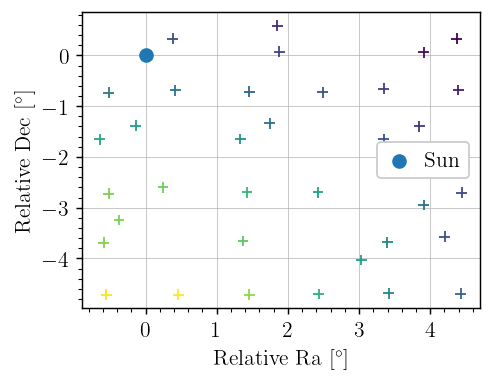

In [51]:
plot_ra_dec(datasets, reference_position=[335.7459, -9.9853], rel=True)

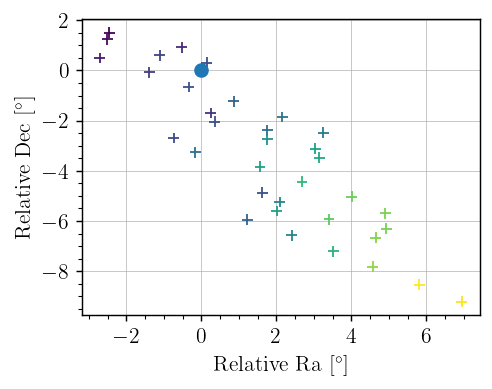

In [50]:
plot_az_alt(datasets, reference_position=[221.764389, 24.164108], rel=True)